Import Library

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.5/263.5 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.8 MB/s eta 0:00:00


In [ ]:
from keras.datasets import fashion_mnist, mnist
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import wandb
import seaborn as sn

**Plotting various Categories of data**

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
# MetaData of Fashion_Mnist dataset ...
CLASSES = {
  0:'T-shirt/top',
  1:'Trouser',
  2:'Pullover',
  3:'Dress',
  4:'Coat',
  5:'Sandal',
  6:'Shirt',
  7:'Sneaker',
  8:'Bag',
  9:'Ankle boot'
}

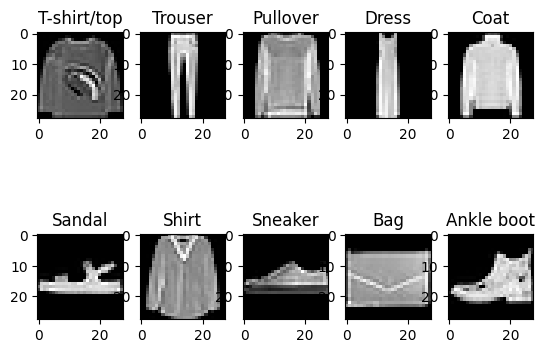

In [ ]:
ind_of_first_occurance = np.argsort(y_train)
ind = ind_of_first_occurance[np.searchsorted(y_train, np.arange(0,10,1), sorter=ind_of_first_occurance)]
fig, ax = plt.subplots(nrows=2, ncols=5)
for i in range(10):
  ax[i//5, i%5].imshow(x_train[ind[i]], cmap='gray')
  ax[i//5, i%5].set_title(CLASSES[i])


# wandb.init(project="cs6910_assignment1")
# wandb.run.name = f'List of Categories'
# wandb.log({'List of Categories':plt})
# wandb.finish()

# fig.suptitle('List of Categories')
plt.show()

In [ ]:
def load_data(dataset='fashion_mnist', purpose='train'):
  dataset=dataset.lower()
  purpose=purpose.lower()
  x,x_t,y,y_t = None,None,None,None

  if dataset == 'fashion_mnist':
    (x, y), (x_t, y_t) = fashion_mnist.load_data()
  elif dataset == 'mnist':
    (x, y), (x_t, y_t) = mnist.load_data()

  if purpose == 'train':
    x = x.reshape(x.shape[0], 784) / 255
    y = np.eye(10)[y]
    return x, y
  elif purpose == 'test':
    x_t = x_t.reshape(x_t.shape[0], 784) / 255
    y_t = np.eye(10)[y_t]
    return x_t, y_t

**Feed Forward Neural Net**

In [ ]:
class FF_NN:

  def __init__(self, param):
    self.hidden_layers = param['hidden_lyrs']
    self.neurons = param['neurons']
    self.input_neurons = param['inpt_sz']
    self.output_neurons = param['oupt_sz']
    self.weights = []
    self.bias = []
    self.activation = param['activation']
    self.output_activation = param['oupt_activation']
    self.weight_initialisation = param['weight_initialisation']

    self.get_weights()
    self.get_bias()


  def get_bias(self):
    for _ in range(self.hidden_layers):
      self.bias.append(np.random.randn(self.neurons))
    self.bias.append(np.random.randn(self.output_neurons))

  def get_weights(self):
    if self.weight_initialisation.lower() == 'random':
      self.weights.append(np.random.randn(self.input_neurons, self.neurons))
      for _ in range(self.hidden_layers-1):
        self.weights.append(np.random.randn(self.neurons, self.neurons))
      self.weights.append(np.random.randn(self.neurons, self.output_neurons))

    else:
      limit = np.sqrt(6/(self.input_neurons + self.neurons))
      self.weights.append(np.random.uniform(low=-limit, high=limit, size=(self.input_neurons, self.neurons)))
      limit = np.sqrt(6/(self.neurons + self.neurons))
      for _ in range(self.hidden_layers-1):
        self.weights.append(np.random.uniform(low=-limit, high=limit, size=(self.neurons, self.neurons)))
      limit = np.sqrt(6/(self.neurons + self.output_neurons))
      self.weights.append(np.random.uniform(low=-limit, high=limit, size=(self.neurons, self.output_neurons)))


  def apply_activation(self, data):
    act = self.activation.lower()
    if act == 'sigmoid':
      data = np.maximum(data, -500)
      data = np.minimum(data, 500)
      return 1/(1+np.exp(-data))
    elif act == 'relu':
      return np.maximum(0,data)
    elif act == 'tanh':
      return np.tanh(data)
    elif act == 'identity':
      return data


  def apply_output_activation(self, data):
    if self.output_activation.lower() == 'softmax':
      data = np.maximum(data, -500)
      data = np.minimum(data, 500)
      data = np.exp(data)
      return data/np.sum(data,axis=1).reshape(data.shape[0],1)


  def feed_forward(self, input):
    self.A = [input]
    self.H = [input]

    # hidden layer calculations...
    for i in range(self.hidden_layers):
      self.A.append(self.bias[i] + np.matmul(self.H[-1], self.weights[i]))
      self.H.append(self.apply_activation(self.A[-1]))

    # output layer calculations...
    self.A.append(self.bias[-1] + np.matmul(self.H[-1], self.weights[-1]))
    self.H.append(self.apply_output_activation(self.A[-1]))

    return self.H[-1] # shape of H[-1] = 60000,10   shape of H = layers, 60000, neurons in each layer


In [ ]:
# nn = FF_NN(PARAMETERS)
# x_train, y_train = load_data(PARAMETERS['dataset'], 'train')
# prediction = nn.feed_forward(x_train) # shape of xtrain -> 60000,784
# print(prediction[0])

**Back_Propagation**

In [ ]:
class BP_NN:

  def __init__(
      self,
      ff_nn:FF_NN,
      param):
    self.ff_nn, self.loss, self.activation, self.output_activation = ff_nn, param['loss_function'], param['activation'], param['oupt_activation']

  def loss_derivative(self, y, y_pred):
    ls = self.loss.lower()
    if ls == "cross_entropy":
      return -y / y_pred
    elif ls == "mse":
      return y_pred - y

  def activation_derivative(self, x):
    act = self.activation.lower()
    if act == "sigmoid":
      return x * (1 - x)
    elif act == "tanh":
      return 1 - x ** 2
    elif act == "relu":
      return (x > 0).astype(int)
    elif act == "identity":
      return np.ones(x.shape)

  def propogate_backward(self, y, y_pred):  # y=60000,10   y_pred=60000,10
    self.d_h, self.d_a, self.delta_weights, self.delta_bias = [], [], [], []

    self.d_a.append(y_pred-y)

    for i in range(self.ff_nn.hidden_layers, 0, -1):
      self.delta_weights.append(np.matmul(self.ff_nn.H[i].T, self.d_a[-1]))
      self.delta_bias.append(np.sum(self.d_a[-1], axis=0))
      self.d_h.append(np.matmul(self.d_a[-1], self.ff_nn.weights[i].T))
      self.d_a.append(self.d_h[-1] * self.activation_derivative(self.ff_nn.H[i]))

    self.delta_weights.append(np.matmul(self.ff_nn.H[0].T, self.d_a[-1]))
    self.delta_bias.append(np.sum(self.d_a[-1], axis=0))

    self.delta_weights.reverse()
    self.delta_bias.reverse()
    for i in range(len(self.delta_weights)):
      self.delta_weights[i] = self.delta_weights[i] / y.shape[0]
      self.delta_bias[i] = self.delta_bias[i] / y.shape[0]

    return self.delta_weights, self.delta_bias

**Optimizers**

In [ ]:
class Optimizer():
  def __init__(
      self,
      ff_nn: FF_NN,
      bp_nn: BP_NN,
      param
  ):
    self.ff_nn, self.bp_nn, self.lr, self.optimizer, self.momentum, self.decay = ff_nn, bp_nn, param['learning_rate'], param['optimizer'], param['momentum'], param['decay']
    self.B1, self.B2, self.eps, self.t = param['beta1'], param['beta2'], param['epsilon'], 0
    self.b_history = [np.zeros_like(i) for i in self.ff_nn.bias]
    self.hm_biases = [np.zeros_like(i) for i in self.ff_nn.bias]
    self.w_history = [np.zeros_like(i) for i in self.ff_nn.weights]
    self.hm_weights = [np.zeros_like(i) for i in self.ff_nn.weights]


  def optimize(self, delta_weights, delta_bias):
    opt = self.optimizer.lower()
    if(opt == "sgd"):
      self.SGD(delta_weights, delta_bias)
    elif(opt == "momentum"):
      self.MGD(delta_weights, delta_bias)
    elif(opt == "nesterov"):
      self.NAG(delta_weights, delta_bias)
    elif(opt == "rmsprop"):
      self.RMSPROP(delta_weights, delta_bias)
    elif(opt == "adam"):
      self.ADAM(delta_weights, delta_bias)
    elif(opt == "nadam"):
      self.NADAM(delta_weights, delta_bias)


  def SGD(self, delta_weights, delta_bias):
    for i in range(self.ff_nn.hidden_layers + 1):
      self.ff_nn.weights[i] -= self.lr * (delta_weights[i] + self.ff_nn.weights[i]*self.decay)
      self.ff_nn.bias[i] -= self.lr * (delta_bias[i] + self.ff_nn.bias[i]*self.decay)

  def MGD(self, delta_weights, delta_bias):
    for i in range(self.ff_nn.hidden_layers + 1):
      self.w_history[i] = self.momentum * self.w_history[i] + delta_weights[i]
      self.ff_nn.weights[i] -= self.lr * (self.w_history[i] + self.ff_nn.weights[i]*self.decay)
      self.b_history[i] = self.momentum * self.b_history[i] + delta_bias[i]
      self.ff_nn.bias[i] -= self.lr * (self.b_history[i] + self.ff_nn.bias[i]*self.decay)

  def NAG(self, delta_weights, delta_bias):
    for i in range(self.ff_nn.hidden_layers + 1):
      self.w_history[i] = self.momentum * self.w_history[i] + delta_weights[i]
      self.ff_nn.weights[i] -= self.lr * (self.momentum * self.w_history[i] + delta_weights[i] + self.ff_nn.weights[i]*self.decay)
      self.b_history[i] = self.momentum * self.b_history[i] + delta_bias[i]
      self.ff_nn.bias[i] -= self.lr * (self.momentum * self.b_history[i] + delta_bias[i] + self.ff_nn.bias[i]*self.decay)


  def RMSPROP(self, delta_weights, delta_bias):
    for i in range(self.ff_nn.hidden_layers + 1):
      self.w_history[i] = self.w_history[i]*self.momentum + (1-self.momentum)*delta_weights[i]**2
      self.ff_nn.weights[i] -= delta_weights[i]*(self.lr / (np.sqrt(self.w_history[i]) + self.eps)) + self.decay * self.ff_nn.weights[i] * self.lr
      self.b_history[i] = self.b_history[i]*self.momentum + (1-self.momentum)*delta_bias[i]**2
      self.ff_nn.bias[i] -= delta_bias[i]*(self.lr / (np.sqrt(self.b_history[i]) + self.eps)) + self.decay * self.ff_nn.bias[i] * self.lr


  def ADAM(self, delta_weights, delta_bias):
    for i in range(self.ff_nn.hidden_layers + 1):
      self.hm_weights[i] = self.B1 * self.hm_weights[i] + (1 - self.B1) * delta_weights[i]
      self.w_history[i] = self.B2 * self.w_history[i] + (1 - self.B2) * delta_weights[i]**2
      self.hm_weights_hat = self.hm_weights[i] / (1 - self.B1**(self.t + 1))
      self.w_history_hat = self.w_history[i] / (1 - self.B2**(self.t + 1))
      self.ff_nn.weights[i] -= self.lr * (self.hm_weights_hat / ((np.sqrt(self.w_history_hat)) + self.eps) + self.decay * self.ff_nn.weights[i])

      self.hm_biases[i] = self.B1 * self.hm_biases[i] + (1 - self.B1) * delta_bias[i]
      self.b_history[i] = self.B2 * self.b_history[i] + (1 - self.B2) * delta_bias[i]**2
      self.hm_biases_hat = self.hm_biases[i] / (1 - self.B1**(1+self.t))
      self.b_history_hat = self.b_history[i] / (1 - self.B2**(1+self.t))
      self.ff_nn.bias[i] -= self.lr * (self.hm_biases_hat / ((np.sqrt(self.b_history_hat)) + self.eps) + self.decay * self.ff_nn.bias[i])


  def NADAM(self, delta_weights, delta_bias):
    for i in range(self.ff_nn.hidden_layers + 1):
      self.hm_weights[i] = self.B1 * self.hm_weights[i] + (1 - self.B1) * delta_weights[i]
      self.hm_weights_hat = self.hm_weights[i] / (1 - self.B1 ** (self.t + 1))
      self.w_history[i] = self.B2 * self.w_history[i] + (1 - self.B2) * delta_weights[i]**2
      self.w_history_hat = self.w_history[i] / (1 - self.B2 ** (self.t + 1))
      w_temp = self.B1 * self.hm_weights_hat + ((1 - self.B1) / (1 - self.B1 ** (self.t + 1))) * delta_weights[i]
      self.ff_nn.weights[i] -= self.lr * (w_temp / ((np.sqrt(self.w_history_hat)) + self.eps) + self.decay * self.ff_nn.weights[i])


      self.hm_biases[i] = self.B1 * self.hm_biases[i] + (1 - self.B1) * delta_bias[i]
      self.hm_biases_hat = self.hm_biases[i] / (1 - self.B1 ** (self.t + 1))
      self.b_history[i] = self.B2 * self.b_history[i] + (1 - self.B2) * delta_bias[i]**2
      self.b_history_hat = self.b_history[i] / (1 - self.B2 ** (self.t + 1))
      b_temp = self.B1 * self.hm_biases_hat + ((1 - self.B1) / (1 - self.B1 ** (self.t + 1))) * delta_bias[i]
      self.ff_nn.bias[i] -= self.lr * (b_temp / ((np.sqrt(self.b_history_hat)) + self.eps) + self.decay * self.ff_nn.bias[i])


In [ ]:
def calculate_loss(y, y_pred, loss_function):
  ls_fn = loss_function.lower()
  if ls_fn == "mean_squared_error":
    return np.sum((y_pred-y) ** 2) / y.shape[0]
  elif ls_fn == "cross_entropy":
    return (-np.sum(y * np.log(y_pred))) / y.shape[0]


In [ ]:
# def train(PARAMETERS):
#   # wandb.init()
#   # config = wandb.config
#   x_train, y_train = load_data(PARAMETERS['dataset'], 'train')
#   np.random.seed(7)
#   ff_nn = FF_NN(PARAMETERS)
#   bp_nn = BP_NN(ff_nn, PARAMETERS)
#   opt = Optimizer(ff_nn, bp_nn, PARAMETERS)
#   print("Initial Accuracy: {}".format(np.sum(np.argmax(ff_nn.feed_forward(x_train), axis=1) == np.argmax(y_train, axis=1)) / y_train.shape[0]))
#   batch_size = PARAMETERS['batch_sz']
#   # wandb.run.name = f'hl_{config.hidden_lyrs}_bs_{config.batch_sz}_ac_{config.activation}'
#   x_train, x_train_t, y_train, y_train_t = train_test_split(x_train, y_train, test_size=0.1, random_state=7)

#   for epoch in range(PARAMETERS['epochs']):
#     for i in range(0, x_train.shape[0], batch_size):
#       y_batch = y_train[i:i+batch_size]
#       x_batch = x_train[i:i+batch_size]
#       opt.optimize(*bp_nn.propogate_backward(y_batch, ff_nn.feed_forward(x_batch)))

#     opt.t += 1
#     y_pred = ff_nn.feed_forward(x_train)
#     y_pred_t = ff_nn.feed_forward(x_train_t)
#     # lg={
#     #     'accuracy':np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_train, axis=1)) / y_train.shape[0],
#     #     'val_accuracy':np.sum(np.argmax(y_pred_t, axis=1) == np.argmax(y_train_t, axis=1)) / y_train_t.shape[0],
#     #     'epoch':epoch+1,
#     #     'loss':calculate_loss(y_train, y_pred, PARAMETERS['loss_function']),
#     #     'validation_loss':calculate_loss(y_train_t, y_pred_t, PARAMETERS['loss_function'])
#     # }
#     # wandb.log(lg)
#     print("epoch-",epoch+1)
#     print("accuracy-",np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_train, axis=1)) / y_train.shape[0])
#     print("loss-", calculate_loss(y_train, y_pred, PARAMETERS['loss_function']))
#     print("validation_acc-",np.sum(np.argmax(y_pred_t, axis=1) == np.argmax(y_train_t, axis=1)) / y_train_t.shape[0])
#     print("validation_loss-", calculate_loss(y_train_t, y_pred_t, PARAMETERS['loss_function']))


#   return ff_nn


In [ ]:
# PARAMETERS = {
#     'inpt_sz' : 784,
#     'oupt_sz' : 10,
#     'neurons' : 64,
#     'hidden_lyrs' : 4,
#     'activation' : 'sigmoid',
#     'oupt_activation' : 'softmax',
#     'dataset' : 'fashion_mnist',
#     'loss_function': 'cross_entropy',
#     'learning_rate': 0.001,
#     'optimizer': 'adam',
#     'momentum': 0.9,
#     'batch_sz': 16,
#     'epochs': 10,
#     'weight_initialisation': 'random',
#     'decay': 0.005,
#     'beta': 0.9,
#     'beta1': 0.9,
#     'beta2': 0.999,
#     'epsilon': 1e-10
# }

In [ ]:
# train(PARAMETERS)

In [ ]:
def train():
  wandb.init()
  PARAMETERS = wandb.config
  x_train, y_train = load_data(PARAMETERS['dataset'], 'train')
  np.random.seed(7)
  ff_nn = FF_NN(PARAMETERS)
  bp_nn = BP_NN(ff_nn, PARAMETERS)
  opt = Optimizer(ff_nn, bp_nn, PARAMETERS)
  print("Initial Accuracy: {}".format(np.sum(np.argmax(ff_nn.feed_forward(x_train), axis=1) == np.argmax(y_train, axis=1)) / y_train.shape[0]))
  batch_size = PARAMETERS['batch_sz']

  wandb.run.name = f'hl_{PARAMETERS.hidden_lyrs}_bs_{PARAMETERS.batch_sz}_ac_{PARAMETERS.activation}'
  x_train, x_train_t, y_train, y_train_t = train_test_split(x_train, y_train, test_size=0.1, random_state=7)

  for epoch in range(PARAMETERS['epochs']):
    for i in range(0, x_train.shape[0], batch_size):
      y_batch = y_train[i:i+batch_size]
      x_batch = x_train[i:i+batch_size]
      y_pred = ff_nn.feed_forward(x_batch)
      weight_change, bias_change = bp_nn.propogate_backward(y_batch, y_pred)
      opt.optimize(weight_change, bias_change)

    opt.t += 1
    y_pred = ff_nn.feed_forward(x_train)
    y_pred_t = ff_nn.feed_forward(x_train_t)
    lg={
        'accuracy':np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_train, axis=1)) / y_train.shape[0],
        'val_accuracy':np.sum(np.argmax(y_pred_t, axis=1) == np.argmax(y_train_t, axis=1)) / y_train_t.shape[0],
        'epoch':epoch+1,
        'loss':calculate_loss(y_train, y_pred, PARAMETERS['loss_function']),
        'validation_loss':calculate_loss(y_train_t, y_pred_t, PARAMETERS['loss_function'])
    }
    wandb.log(lg)
    print("epoch-",epoch+1)
    print("accuracy-",np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_train, axis=1)) / y_train.shape[0])
    print("loss-", calculate_loss(y_train, y_pred, PARAMETERS['loss_function']))
    print("validation-",np.sum(np.argmax(y_pred_t, axis=1) == np.argmax(y_train_t, axis=1)) / y_train_t.shape[0])


  return ff_nn


In [ ]:
sweep_config = {
    "method": "bayes",
    "name": "Q4 WandB sweep",
    "metric": {"goal": "maximize", "name": "accuracy"},
    "parameters": {
        "inpt_sz": {"values": [784]},
        "oupt_sz": {"values": [10]},
        "oupt_activation": {"values": ["softmax"]},
        "dataset": {"values": ["fashion_mnist"]},
        "loss_function": {"values": ["cross_entropy"]},
        "beta": {"values": [0.9]},
        "beta1": {"values": [0.9]},
        "beta2": {"values": [0.999]},
        "neurons": {"values": [32, 64, 128]},
        "hidden_lyrs": {"values": [3, 4, 5]},
        "activation": {"values": ["relu", "tanh", "sigmoid"]},
        "learning_rate": {"values": [1e-3, 1e-4]},
        "optimizer": {"values": ['adam', 'sgd', 'nesterov', 'rmsprop', 'momentum', 'nadam']},
        "momentum": {"values": [0.8, 0.9]},
        "batch_sz": {"values": [16, 32, 64]},
        "epochs": {"values": [5, 10]},
        "weight_initialisation": {"values": ["random", "xavier"]},
        "decay": {"values": [0, 0.0005, 0.5]},
        "epsilon": {"values": [1e-8, 1e-10]},
    }
}


In [ ]:
sweep_id = wandb.sweep(sweep_config, project="cs6910_assignment1")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: 9jd3qay1
Sweep URL: https://wandb.ai/cs23m070/cs6910_assignment1/sweeps/9jd3qay1


In [ ]:
wandb.agent(sweep_id, function=train, count=50)
wandb.finish()

wandb: Agent Starting Run: 6r94yyij with config:
wandb: 	activation: tanh
wandb: 	batch_sz: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.5
wandb: 	epochs: 10
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 3
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.9
wandb: 	neurons: 128
wandb: 	optimizer: rmsprop
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: random
wandb: Currently logged in as: cs23m070. Use `wandb login --relogin` to force relogin


Initial Accuracy: 0.0958
epoch- 1
accuracy- 0.755425925925926
loss- 0.6722024914728773
validation- 0.7483333333333333
epoch- 2
accuracy- 0.8080925925925926
loss- 0.5012618340933482
validation- 0.7953333333333333
epoch- 3
accuracy- 0.8194814814814815
loss- 0.4861118960173829
validation- 0.8168333333333333
epoch- 4
accuracy- 0.8182592592592592
loss- 0.49427107556642896
validation- 0.8111666666666667
epoch- 5
accuracy- 0.8112962962962963
loss- 0.513536927418634
validation- 0.8071666666666667
epoch- 6
accuracy- 0.8082407407407407
loss- 0.524765696193687
validation- 0.803
epoch- 7
accuracy- 0.8102777777777778
loss- 0.5208285113900359
validation- 0.806
epoch- 8
accuracy- 0.8125370370370371
loss- 0.5130333614131615
validation- 0.8088333333333333
epoch- 9
accuracy- 0.8130925925925926
loss- 0.5126949967874473
validation- 0.8076666666666666
epoch- 10
accuracy- 0.8071851851851852
loss- 0.5313852718536092
validation- 0.8


accuracy,▁▇██▇▇▇▇▇▇
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▁▁▂▂▂▂▂▃
val_accuracy,▁▆█▇▇▇▇▇▇▆
validation_loss,█▂▁▁▂▂▂▂▂▃
accuracy,0.80719
epoch,10
loss,0.53139
val_accuracy,0.8
validation_loss,0.56511


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zf7c9z0r with config:
wandb: 	activation: sigmoid
wandb: 	batch_sz: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 3
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 64
wandb: 	optimizer: rmsprop
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: random


Initial Accuracy: 0.0849
epoch- 1
accuracy- 0.8044814814814815
loss- 0.547960291459954
validation- 0.8006666666666666
epoch- 2
accuracy- 0.829037037037037
loss- 0.4788223933177137
validation- 0.817
epoch- 3
accuracy- 0.8414259259259259
loss- 0.4473571421405074
validation- 0.8286666666666667
epoch- 4
accuracy- 0.8492592592592593
loss- 0.4282454391847992
validation- 0.8411666666666666
epoch- 5
accuracy- 0.8547592592592592
loss- 0.4205461303855015
validation- 0.844
epoch- 6
accuracy- 0.8615185185185186
loss- 0.40055822002040314
validation- 0.8461666666666666
epoch- 7
accuracy- 0.8630925925925926
loss- 0.39396042810034426
validation- 0.848
epoch- 8
accuracy- 0.8680555555555556
loss- 0.38449193078941013
validation- 0.8526666666666667
epoch- 9
accuracy- 0.8719259259259259
loss- 0.3785926016757048
validation- 0.854
epoch- 10
accuracy- 0.8737777777777778
loss- 0.3721095562396737
validation- 0.8558333333333333


accuracy,▁▃▅▆▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▃▅▆▆▇▇███
validation_loss,█▅▃▂▂▁▁▁▁▁
accuracy,0.87378
epoch,10
loss,0.37211
val_accuracy,0.85583
validation_loss,0.45648


wandb: Agent Starting Run: gv2crpfb with config:
wandb: 	activation: tanh
wandb: 	batch_sz: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_lyrs: 5
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.9
wandb: 	neurons: 32
wandb: 	optimizer: adam
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: random


Initial Accuracy: 0.08973333333333333
epoch- 1
accuracy- 0.3502962962962963
loss- 2.0989140772636103
validation- 0.3481666666666667
epoch- 2
accuracy- 0.4137037037037037
loss- 1.7089508641629252
validation- 0.4086666666666667
epoch- 3
accuracy- 0.4595185185185185
loss- 1.5268283317556874
validation- 0.45366666666666666
epoch- 4
accuracy- 0.5051666666666667
loss- 1.4100948895798806
validation- 0.49666666666666665
epoch- 5
accuracy- 0.5249259259259259
loss- 1.3337543439420185
validation- 0.5126666666666667


accuracy,▁▄▅▇█
epoch,▁▃▅▆█
loss,█▄▃▂▁
val_accuracy,▁▄▅▇█
validation_loss,█▄▃▂▁
accuracy,0.52493
epoch,5
loss,1.33375
val_accuracy,0.51267
validation_loss,1.37754


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: spr97v4r with config:
wandb: 	activation: tanh
wandb: 	batch_sz: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.5
wandb: 	epochs: 10
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 4
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.9
wandb: 	neurons: 128
wandb: 	optimizer: nadam
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: random


Initial Accuracy: 0.1036
epoch- 1
accuracy- 0.769537037037037
loss- 0.6516704719269901
validation- 0.7641666666666667
epoch- 2
accuracy- 0.8122962962962963
loss- 0.5745395538701438
validation- 0.8121666666666667
epoch- 3
accuracy- 0.8226851851851852
loss- 0.5280145587061427
validation- 0.8203333333333334
epoch- 4
accuracy- 0.8278888888888889
loss- 0.5215977346357282
validation- 0.8248333333333333
epoch- 5
accuracy- 0.8286296296296296
loss- 0.5236014991743052
validation- 0.8265
epoch- 6
accuracy- 0.8278888888888889
loss- 0.5276166944905184
validation- 0.8266666666666667
epoch- 7
accuracy- 0.827037037037037
loss- 0.5312910296986402
validation- 0.8265
epoch- 8
accuracy- 0.8252777777777778
loss- 0.5348567851713866
validation- 0.8236666666666667
epoch- 9
accuracy- 0.8235555555555556
loss- 0.5373108478875879
validation- 0.8228333333333333
epoch- 10
accuracy- 0.8231481481481482
loss- 0.5380781156748592
validation- 0.8223333333333334


accuracy,▁▆▇█████▇▇
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▁▁▁▁▂▂▂▂
val_accuracy,▁▆▇███████
validation_loss,█▄▁▁▁▁▁▂▂▂
accuracy,0.82315
epoch,10
loss,0.53808
val_accuracy,0.82233
validation_loss,0.54957


wandb: Agent Starting Run: q3ljrtfa with config:
wandb: 	activation: tanh
wandb: 	batch_sz: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 3
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 128
wandb: 	optimizer: nadam
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.11096666666666667
epoch- 1
accuracy- 0.864537037037037
loss- 0.3676414233973265
validation- 0.86
epoch- 2
accuracy- 0.8804814814814815
loss- 0.3232624591556491
validation- 0.8698333333333333
epoch- 3
accuracy- 0.889537037037037
loss- 0.2977910918907706
validation- 0.8738333333333334
epoch- 4
accuracy- 0.8959444444444444
loss- 0.2802867254886296
validation- 0.8768333333333334
epoch- 5
accuracy- 0.9005555555555556
loss- 0.2671224234675015
validation- 0.8793333333333333
epoch- 6
accuracy- 0.9043148148148148
loss- 0.25620953295195925
validation- 0.881
epoch- 7
accuracy- 0.9078703703703703
loss- 0.24662986246089388
validation- 0.8816666666666667
epoch- 8
accuracy- 0.9112407407407408
loss- 0.23799843588721586
validation- 0.882
epoch- 9
accuracy- 0.9137777777777778
loss- 0.23006503245073825
validation- 0.8826666666666667
epoch- 10
accuracy- 0.9164074074074074
loss- 0.22274023011647162
validation- 0.8823333333333333


accuracy,▁▃▄▅▆▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▄▅▆▇▇████
validation_loss,█▅▄▃▂▂▁▁▁▁
accuracy,0.91641
epoch,10
loss,0.22274
val_accuracy,0.88233
validation_loss,0.31803


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o37x90uw with config:
wandb: 	activation: sigmoid
wandb: 	batch_sz: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 5
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 3
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 128
wandb: 	optimizer: nadam
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.1
epoch- 1
accuracy- 0.8343703703703703
loss- 0.45565593272147653
validation- 0.829
epoch- 2
accuracy- 0.8549629629629629
loss- 0.4009011561748172
validation- 0.847
epoch- 3
accuracy- 0.8657777777777778
loss- 0.37220609746478905
validation- 0.8556666666666667
epoch- 4
accuracy- 0.8727592592592592
loss- 0.35337819856926306
validation- 0.8601666666666666
epoch- 5
accuracy- 0.8778888888888889
loss- 0.33925881650969475
validation- 0.8633333333333333


accuracy,▁▄▆▇█
epoch,▁▃▅▆█
loss,█▅▃▂▁
val_accuracy,▁▅▆▇█
validation_loss,█▅▃▂▁
accuracy,0.87789
epoch,5
loss,0.33926
val_accuracy,0.86333
validation_loss,0.37417


wandb: Agent Starting Run: fmds7pea with config:
wandb: 	activation: relu
wandb: 	batch_sz: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.0005
wandb: 	epochs: 10
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 4
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 128
wandb: 	optimizer: momentum
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.1
epoch- 1
accuracy- 0.68
loss- 1.0542147240004989
validation- 0.672
epoch- 2
accuracy- 0.7314074074074074
loss- 0.7662966277372476
validation- 0.7228333333333333
epoch- 3
accuracy- 0.7553703703703704
loss- 0.6716730803781867
validation- 0.7481666666666666
epoch- 4
accuracy- 0.7718703703703703
loss- 0.6223091966233574
validation- 0.7655
epoch- 5
accuracy- 0.7843703703703704
loss- 0.5891256104890076
validation- 0.7745
epoch- 6
accuracy- 0.7937592592592593
loss- 0.5640034668383953
validation- 0.7861666666666667
epoch- 7
accuracy- 0.8018703703703703
loss- 0.5442061256904004
validation- 0.7948333333333333
epoch- 8
accuracy- 0.8092037037037038
loss- 0.5278439431643864
validation- 0.8026666666666666
epoch- 9
accuracy- 0.8150925925925926
loss- 0.5138932534550219
validation- 0.8063333333333333
epoch- 10
accuracy- 0.8203148148148148
loss- 0.5018005133483795
validation- 0.8106666666666666


accuracy,▁▄▅▆▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇███
validation_loss,█▄▃▃▂▂▂▁▁▁
accuracy,0.82031
epoch,10
loss,0.5018
val_accuracy,0.81067
validation_loss,0.51645


wandb: Agent Starting Run: lwpz8ayw with config:
wandb: 	activation: tanh
wandb: 	batch_sz: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 3
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 128
wandb: 	optimizer: momentum
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.11096666666666667
epoch- 1
accuracy- 0.8008148148148149
loss- 0.5524231151450045
validation- 0.7963333333333333
epoch- 2
accuracy- 0.8298333333333333
loss- 0.46628919672061075
validation- 0.8298333333333333
epoch- 3
accuracy- 0.8443333333333334
loss- 0.42858793095051134
validation- 0.8413333333333334
epoch- 4
accuracy- 0.8526481481481482
loss- 0.40469555167190036
validation- 0.849
epoch- 5
accuracy- 0.859537037037037
loss- 0.3870710799900985
validation- 0.8545
epoch- 6
accuracy- 0.865574074074074
loss- 0.37285851612986676
validation- 0.857
epoch- 7
accuracy- 0.8696666666666667
loss- 0.3608399785861915
validation- 0.8588333333333333
epoch- 8
accuracy- 0.8732962962962963
loss- 0.3503661199806106
validation- 0.8618333333333333
epoch- 9
accuracy- 0.8766111111111111
loss- 0.3410309838807437
validation- 0.8621666666666666
epoch- 10
accuracy- 0.8796481481481482
loss- 0.3325687767294684
validation- 0.8648333333333333


accuracy,▁▄▅▆▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▆▆▇▇▇███
validation_loss,█▅▄▃▂▂▂▁▁▁
accuracy,0.87965
epoch,10
loss,0.33257
val_accuracy,0.86483
validation_loss,0.36749


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nr9qb4qn with config:
wandb: 	activation: sigmoid
wandb: 	batch_sz: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.5
wandb: 	epochs: 10
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 3
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 64
wandb: 	optimizer: nadam
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.1
epoch- 1
accuracy- 0.7134259259259259
loss- 0.9011886258096004
validation- 0.7106666666666667
epoch- 2
accuracy- 0.7050555555555555
loss- 0.9729624582568368
validation- 0.7033333333333334
epoch- 3
accuracy- 0.6893518518518519
loss- 1.032631658581842
validation- 0.689
epoch- 4
accuracy- 0.675037037037037
loss- 1.0712270932434869
validation- 0.6746666666666666
epoch- 5
accuracy- 0.6659814814814815
loss- 1.0982387404302885
validation- 0.6651666666666667
epoch- 6
accuracy- 0.6607037037037037
loss- 1.1175273141369446
validation- 0.6581666666666667
epoch- 7
accuracy- 0.656537037037037
loss- 1.1308436587791708
validation- 0.6526666666666666
epoch- 8
accuracy- 0.6534444444444445
loss- 1.1396803538390672
validation- 0.6483333333333333
epoch- 9
accuracy- 0.6514629629629629
loss- 1.1458188173953519
validation- 0.647
epoch- 10
accuracy- 0.6500555555555556
loss- 1.1498981277294027
validation- 0.6471666666666667


accuracy,█▇▅▄▃▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,▁▃▅▆▇▇▇███
val_accuracy,█▇▆▄▃▂▂▁▁▁
validation_loss,▁▃▅▆▇▇▇███
accuracy,0.65006
epoch,10
loss,1.1499
val_accuracy,0.64717
validation_loss,1.15603


wandb: Agent Starting Run: loorc3qp with config:
wandb: 	activation: sigmoid
wandb: 	batch_sz: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 3
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 64
wandb: 	optimizer: nadam
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.1
epoch- 1
accuracy- 0.48324074074074075
loss- 1.7093818453571408
validation- 0.48083333333333333
epoch- 2
accuracy- 0.5705370370370371
loss- 1.4430542361216565
validation- 0.5638333333333333
epoch- 3
accuracy- 0.6081296296296296
loss- 1.2884543427367785
validation- 0.6031666666666666
epoch- 4
accuracy- 0.6452777777777777
loss- 1.1565735187149355
validation- 0.6391666666666667
epoch- 5
accuracy- 0.6830555555555555
loss- 1.0404625116259076
validation- 0.6793333333333333
epoch- 6
accuracy- 0.7067037037037037
loss- 0.9451683924068338
validation- 0.706
epoch- 7
accuracy- 0.7229629629629629
loss- 0.8691917347590302
validation- 0.7193333333333334
epoch- 8
accuracy- 0.7317592592592592
loss- 0.8087438706313551
validation- 0.7268333333333333
epoch- 9
accuracy- 0.7388518518518519
loss- 0.760721529997092
validation- 0.7333333333333333
epoch- 10
accuracy- 0.7438148148148148
loss- 0.7226546727527454
validation- 0.7386666666666667


accuracy,▁▃▄▅▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▃▄▅▆▇▇███
validation_loss,█▆▅▄▃▃▂▂▁▁
accuracy,0.74381
epoch,10
loss,0.72265
val_accuracy,0.73867
validation_loss,0.73327


wandb: Agent Starting Run: 8rh8s8oi with config:
wandb: 	activation: tanh
wandb: 	batch_sz: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 3
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 128
wandb: 	optimizer: nadam
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.11096666666666667
epoch- 1
accuracy- 0.8206481481481481
loss- 0.5037325469834412
validation- 0.8218333333333333
epoch- 2
accuracy- 0.8386666666666667
loss- 0.4509952804527805
validation- 0.836
epoch- 3
accuracy- 0.8473333333333334
loss- 0.4248929099716849
validation- 0.8418333333333333
epoch- 4
accuracy- 0.8537407407407407
loss- 0.4079205641082915
validation- 0.8463333333333334
epoch- 5
accuracy- 0.8586111111111111
loss- 0.395351317422016
validation- 0.8483333333333334
epoch- 6
accuracy- 0.8626111111111111
loss- 0.3853180902658238
validation- 0.8518333333333333
epoch- 7
accuracy- 0.8648703703703704
loss- 0.37691972138941465
validation- 0.8548333333333333
epoch- 8
accuracy- 0.8679444444444444
loss- 0.36965662461492316
validation- 0.8563333333333333
epoch- 9
accuracy- 0.8702777777777778
loss- 0.3632239318594724
validation- 0.8585
epoch- 10
accuracy- 0.8721111111111111
loss- 0.35742273890313503
validation- 0.861


accuracy,▁▃▅▆▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▅▅▆▆▇▇██
validation_loss,█▅▄▃▃▂▂▂▁▁
accuracy,0.87211
epoch,10
loss,0.35742
val_accuracy,0.861
validation_loss,0.38484


wandb: Agent Starting Run: 5zryiomq with config:
wandb: 	activation: sigmoid
wandb: 	batch_sz: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 3
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 128
wandb: 	optimizer: nadam
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: random


Initial Accuracy: 0.10733333333333334
epoch- 1
accuracy- 0.4867962962962963
loss- 1.5739229897522518
validation- 0.482
epoch- 2
accuracy- 0.5826666666666667
loss- 1.2409811659097563
validation- 0.575
epoch- 3
accuracy- 0.625537037037037
loss- 1.0896083921118822
validation- 0.6113333333333333
epoch- 4
accuracy- 0.6534444444444445
loss- 0.9985853929911601
validation- 0.6366666666666667
epoch- 5
accuracy- 0.673
loss- 0.9361646602240545
validation- 0.6566666666666666
epoch- 6
accuracy- 0.6870925925925926
loss- 0.8895165197314848
validation- 0.6705
epoch- 7
accuracy- 0.6983703703703704
loss- 0.852675405103336
validation- 0.6801666666666667
epoch- 8
accuracy- 0.7077037037037037
loss- 0.8224818346124114
validation- 0.6855
epoch- 9
accuracy- 0.7153703703703703
loss- 0.7970632918642112
validation- 0.6946666666666667
epoch- 10
accuracy- 0.7213703703703703
loss- 0.7752438573717045
validation- 0.6998333333333333


accuracy,▁▄▅▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
validation_loss,█▅▄▃▂▂▂▁▁▁
accuracy,0.72137
epoch,10
loss,0.77524
val_accuracy,0.69983
validation_loss,0.81956


wandb: Agent Starting Run: v20cr3p0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_sz: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 5
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 3
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.9
wandb: 	neurons: 128
wandb: 	optimizer: nadam
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.1
epoch- 1
accuracy- 0.6308703703703704
loss- 1.3117261604463484
validation- 0.628
epoch- 2
accuracy- 0.657
loss- 1.0389378170629964
validation- 0.654
epoch- 3
accuracy- 0.6908333333333333
loss- 0.8897912360408832
validation- 0.686
epoch- 4
accuracy- 0.7210555555555556
loss- 0.7960461351149148
validation- 0.7133333333333334
epoch- 5
accuracy- 0.7432037037037037
loss- 0.7283864631656125
validation- 0.7393333333333333


accuracy,▁▃▅▇█
epoch,▁▃▅▆█
loss,█▅▃▂▁
val_accuracy,▁▃▅▆█
validation_loss,█▅▃▂▁
accuracy,0.7432
epoch,5
loss,0.72839
val_accuracy,0.73933
validation_loss,0.73892


wandb: Agent Starting Run: 9nq4xkcc with config:
wandb: 	activation: tanh
wandb: 	batch_sz: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 3
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.9
wandb: 	neurons: 128
wandb: 	optimizer: nesterov
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.11096666666666667
epoch- 1
accuracy- 0.8244259259259259
loss- 0.4777229861566177
validation- 0.8243333333333334
epoch- 2
accuracy- 0.8471481481481481
loss- 0.4181413864417977
validation- 0.8431666666666666
epoch- 3
accuracy- 0.8589629629629629
loss- 0.38684990132294983
validation- 0.8515
epoch- 4
accuracy- 0.8676296296296296
loss- 0.3647637305951106
validation- 0.8561666666666666
epoch- 5
accuracy- 0.8736296296296296
loss- 0.34744658071416307
validation- 0.8611666666666666
epoch- 6
accuracy- 0.8788703703703704
loss- 0.33302851092847496
validation- 0.8638333333333333
epoch- 7
accuracy- 0.8825925925925926
loss- 0.32063802616946957
validation- 0.8671666666666666
epoch- 8
accuracy- 0.8862962962962962
loss- 0.3097898514994938
validation- 0.8695
epoch- 9
accuracy- 0.8897592592592592
loss- 0.30013490847476443
validation- 0.8721666666666666
epoch- 10
accuracy- 0.8928703703703704
loss- 0.2914504124082508
validation- 0.8743333333333333


accuracy,▁▃▅▅▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▄▅▅▆▇▇▇██
validation_loss,█▅▄▃▃▂▂▂▁▁
accuracy,0.89287
epoch,10
loss,0.29145
val_accuracy,0.87433
validation_loss,0.3428


wandb: Agent Starting Run: if6zozp2 with config:
wandb: 	activation: relu
wandb: 	batch_sz: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_lyrs: 3
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.9
wandb: 	neurons: 128
wandb: 	optimizer: nadam
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.09976666666666667
epoch- 1
accuracy- 0.8590740740740741
loss- 0.3773287694030825
validation- 0.8541666666666666
epoch- 2
accuracy- 0.8789814814814815
loss- 0.3285208921076882
validation- 0.8676666666666667
epoch- 3
accuracy- 0.8869074074074074
loss- 0.3058226426976953
validation- 0.8748333333333334
epoch- 4
accuracy- 0.8939074074074074
loss- 0.28716796593566746
validation- 0.8761666666666666
epoch- 5
accuracy- 0.8981111111111111
loss- 0.2744477912685553
validation- 0.8781666666666667
epoch- 6
accuracy- 0.901
loss- 0.26415085950399264
validation- 0.8805
epoch- 7
accuracy- 0.9044444444444445
loss- 0.25492948689929656
validation- 0.8821666666666667
epoch- 8
accuracy- 0.9073148148148148
loss- 0.24621045964738422
validation- 0.88
epoch- 9
accuracy- 0.9097037037037037
loss- 0.2393660406148674
validation- 0.8803333333333333
epoch- 10
accuracy- 0.912074074074074
loss- 0.23256524221033403
validation- 0.8793333333333333


accuracy,▁▄▅▆▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▄▆▆▇██▇█▇
validation_loss,█▄▃▂▂▁▁▁▁▁
accuracy,0.91207
epoch,10
loss,0.23257
val_accuracy,0.87933
validation_loss,0.32657


wandb: Agent Starting Run: tg86fhan with config:
wandb: 	activation: relu
wandb: 	batch_sz: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 3
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.9
wandb: 	neurons: 64
wandb: 	optimizer: nadam
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.1
epoch- 1
accuracy- 0.8579074074074075
loss- 0.39217463578000733
validation- 0.8526666666666667
epoch- 2
accuracy- 0.8703888888888889
loss- 0.35571606430075114
validation- 0.86
epoch- 3
accuracy- 0.8780555555555556
loss- 0.3337705826974743
validation- 0.8638333333333333
epoch- 4
accuracy- 0.8830555555555556
loss- 0.3188235814642782
validation- 0.8646666666666667
epoch- 5
accuracy- 0.8867222222222222
loss- 0.30841009502035094
validation- 0.8686666666666667
epoch- 6
accuracy- 0.8896851851851851
loss- 0.297668390718206
validation- 0.8736666666666667
epoch- 7
accuracy- 0.8928888888888888
loss- 0.28885607247855366
validation- 0.8731666666666666
epoch- 8
accuracy- 0.8955
loss- 0.28254287147061224
validation- 0.8748333333333334
epoch- 9
accuracy- 0.8982407407407408
loss- 0.27492548001622286
validation- 0.8765
epoch- 10
accuracy- 0.9005185185185185
loss- 0.26863536938239574
validation- 0.8761666666666666


accuracy,▁▃▄▅▆▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▃▄▅▆▇▇███
validation_loss,█▆▄▃▃▂▂▂▁▁
accuracy,0.90052
epoch,10
loss,0.26864
val_accuracy,0.87617
validation_loss,0.33799


wandb: Agent Starting Run: uoir5eyn with config:
wandb: 	activation: relu
wandb: 	batch_sz: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.5
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_lyrs: 4
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.9
wandb: 	neurons: 128
wandb: 	optimizer: nadam
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.1
epoch- 1
accuracy- 0.8452407407407407
loss- 0.45157092005043503
validation- 0.8421666666666666
epoch- 2
accuracy- 0.8489444444444444
loss- 0.4645108073003191
validation- 0.844
epoch- 3
accuracy- 0.8440740740740741
loss- 0.4881923409359672
validation- 0.8403333333333334
epoch- 4
accuracy- 0.8366481481481481
loss- 0.5118401907042825
validation- 0.8346666666666667
epoch- 5
accuracy- 0.8318333333333333
loss- 0.5270979477631892
validation- 0.831
epoch- 6
accuracy- 0.8280925925925926
loss- 0.5386556239347852
validation- 0.827
epoch- 7
accuracy- 0.8238518518518518
loss- 0.5484715795495517
validation- 0.8236666666666667
epoch- 8
accuracy- 0.8226296296296296
loss- 0.5534120189058028
validation- 0.8206666666666667
epoch- 9
accuracy- 0.8230555555555555
loss- 0.5546756361014168
validation- 0.8205
epoch- 10
accuracy- 0.8227407407407408
loss- 0.5554705747055768
validation- 0.8205


accuracy,▇█▇▅▃▂▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,▁▂▃▅▆▇████
val_accuracy,▇█▇▅▄▃▂▁▁▁
validation_loss,▁▂▄▅▆▇▇███
accuracy,0.82274
epoch,10
loss,0.55547
val_accuracy,0.8205
validation_loss,0.56996


wandb: Agent Starting Run: 1z4epiri with config:
wandb: 	activation: relu
wandb: 	batch_sz: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.0005
wandb: 	epochs: 10
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 5
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.9
wandb: 	neurons: 128
wandb: 	optimizer: nadam
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.09133333333333334
epoch- 1
accuracy- 0.8638333333333333
loss- 0.3710945879545283
validation- 0.8576666666666667
epoch- 2
accuracy- 0.8791111111111111
loss- 0.3274939540785269
validation- 0.8666666666666667
epoch- 3
accuracy- 0.889425925925926
loss- 0.3004338902690312
validation- 0.8701666666666666
epoch- 4
accuracy- 0.8961666666666667
loss- 0.2814932589616132
validation- 0.8763333333333333
epoch- 5
accuracy- 0.9015555555555556
loss- 0.2672007200528656
validation- 0.8778333333333334
epoch- 6
accuracy- 0.9054629629629629
loss- 0.25665571301308543
validation- 0.881
epoch- 7
accuracy- 0.9078703703703703
loss- 0.24885175787289945
validation- 0.881
epoch- 8
accuracy- 0.9118148148148149
loss- 0.2382341117799349
validation- 0.8833333333333333
epoch- 9
accuracy- 0.9141481481481482
loss- 0.23193445397864956
validation- 0.8828333333333334
epoch- 10
accuracy- 0.9152222222222223
loss- 0.22789209130793908
validation- 0.882


accuracy,▁▃▄▅▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▂▂▂▁▁
val_accuracy,▁▃▄▆▆▇▇███
validation_loss,█▅▃▂▂▁▁▁▁▂
accuracy,0.91522
epoch,10
loss,0.22789
val_accuracy,0.882
validation_loss,0.33233


wandb: Agent Starting Run: 13jre2bn with config:
wandb: 	activation: relu
wandb: 	batch_sz: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_lyrs: 4
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.9
wandb: 	neurons: 128
wandb: 	optimizer: nadam
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.1
epoch- 1
accuracy- 0.8642037037037037
loss- 0.3668909272243965
validation- 0.8571666666666666
epoch- 2
accuracy- 0.8810370370370371
loss- 0.32002653996683095
validation- 0.8691666666666666
epoch- 3
accuracy- 0.8892222222222222
loss- 0.2972165930330137
validation- 0.8705
epoch- 4
accuracy- 0.8959259259259259
loss- 0.27812744837643394
validation- 0.877
epoch- 5
accuracy- 0.9009444444444444
loss- 0.26478470963666356
validation- 0.8788333333333334
epoch- 6
accuracy- 0.9040555555555555
loss- 0.2547746960173039
validation- 0.879
epoch- 7
accuracy- 0.9076666666666666
loss- 0.24560534003470333
validation- 0.8808333333333334
epoch- 8
accuracy- 0.910537037037037
loss- 0.23816908730354344
validation- 0.8806666666666667
epoch- 9
accuracy- 0.9132962962962963
loss- 0.2304677996309944
validation- 0.881
epoch- 10
accuracy- 0.9159444444444444
loss- 0.22338345786087788
validation- 0.8826666666666667


accuracy,▁▃▄▅▆▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▄▅▆▇▇▇▇██
validation_loss,█▅▃▂▂▁▁▁▁▁
accuracy,0.91594
epoch,10
loss,0.22338
val_accuracy,0.88267
validation_loss,0.32032


wandb: Agent Starting Run: c0wnru6v with config:
wandb: 	activation: sigmoid
wandb: 	batch_sz: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 4
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 128
wandb: 	optimizer: nadam
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.1
epoch- 1
accuracy- 0.8184074074074074
loss- 0.5156026527124219
validation- 0.8145
epoch- 2
accuracy- 0.8453518518518518
loss- 0.43709492091105967
validation- 0.8383333333333334
epoch- 3
accuracy- 0.8566296296296296
loss- 0.402987433913691
validation- 0.85
epoch- 4
accuracy- 0.8648518518518519
loss- 0.37974556360582923
validation- 0.8525
epoch- 5
accuracy- 0.871537037037037
loss- 0.3613297163643647
validation- 0.856
epoch- 6
accuracy- 0.8766111111111111
loss- 0.3460233073886723
validation- 0.8575
epoch- 7
accuracy- 0.881425925925926
loss- 0.33304621087647224
validation- 0.862
epoch- 8
accuracy- 0.8856851851851851
loss- 0.32184377824715255
validation- 0.8656666666666667
epoch- 9
accuracy- 0.8887777777777778
loss- 0.3121493937555477
validation- 0.8691666666666666
epoch- 10
accuracy- 0.8910370370370371
loss- 0.3037780405007861
validation- 0.8701666666666666


accuracy,▁▄▅▅▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▄▃▂▂▂▁▁
val_accuracy,▁▄▅▆▆▆▇▇██
validation_loss,█▅▄▃▃▂▂▂▁▁
accuracy,0.89104
epoch,10
loss,0.30378
val_accuracy,0.87017
validation_loss,0.35559


wandb: Agent Starting Run: m6dsjcpu with config:
wandb: 	activation: relu
wandb: 	batch_sz: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 3
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.9
wandb: 	neurons: 128
wandb: 	optimizer: nadam
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.09976666666666667
epoch- 1
accuracy- 0.8139444444444445
loss- 0.5274018259890632
validation- 0.8085
epoch- 2
accuracy- 0.8305185185185185
loss- 0.4784373526457239
validation- 0.8275
epoch- 3
accuracy- 0.8401481481481482
loss- 0.4534566091651698
validation- 0.8358333333333333
epoch- 4
accuracy- 0.8456666666666667
loss- 0.43731195434248105
validation- 0.8401666666666666
epoch- 5
accuracy- 0.8494074074074074
loss- 0.42516077114867373
validation- 0.8428333333333333
epoch- 6
accuracy- 0.8528703703703704
loss- 0.4154278737763747
validation- 0.8453333333333334
epoch- 7
accuracy- 0.8561296296296297
loss- 0.4070399958633275
validation- 0.8491666666666666
epoch- 8
accuracy- 0.8590925925925926
loss- 0.3996509270292952
validation- 0.8516666666666667
epoch- 9
accuracy- 0.8610185185185185
loss- 0.3928430565542327
validation- 0.8536666666666667
epoch- 10
accuracy- 0.863
loss- 0.3867487290087138
validation- 0.8546666666666667


accuracy,▁▃▅▆▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▄▄▃▂▂▂▁▁
val_accuracy,▁▄▅▆▆▇▇███
validation_loss,█▅▄▃▃▂▂▂▁▁
accuracy,0.863
epoch,10
loss,0.38675
val_accuracy,0.85467
validation_loss,0.40995


wandb: Agent Starting Run: rjsmx93z with config:
wandb: 	activation: relu
wandb: 	batch_sz: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.0005
wandb: 	epochs: 10
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 4
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.9
wandb: 	neurons: 128
wandb: 	optimizer: nadam
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.1
epoch- 1
accuracy- 0.8652777777777778
loss- 0.3665571217378238
validation- 0.859
epoch- 2
accuracy- 0.8797037037037037
loss- 0.32378494678651715
validation- 0.8676666666666667
epoch- 3
accuracy- 0.8877037037037037
loss- 0.2999476137009549
validation- 0.8716666666666667
epoch- 4
accuracy- 0.8946666666666667
loss- 0.2813002582595098
validation- 0.8771666666666667
epoch- 5
accuracy- 0.8997222222222222
loss- 0.266688915100449
validation- 0.8801666666666667
epoch- 6
accuracy- 0.9029814814814815
loss- 0.2577423158006275
validation- 0.8803333333333333
epoch- 7
accuracy- 0.9068148148148149
loss- 0.24942846898584187
validation- 0.8806666666666667
epoch- 8
accuracy- 0.9096111111111111
loss- 0.2411741079430579
validation- 0.8816666666666667
epoch- 9
accuracy- 0.9118333333333334
loss- 0.233537134078137
validation- 0.8828333333333334
epoch- 10
accuracy- 0.9150555555555555
loss- 0.22572820394610574
validation- 0.8815


accuracy,▁▃▄▅▆▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▄▅▆▇▇▇███
validation_loss,█▅▄▃▂▁▁▁▁▁
accuracy,0.91506
epoch,10
loss,0.22573
val_accuracy,0.8815
validation_loss,0.31826


wandb: Agent Starting Run: f13wjd38 with config:
wandb: 	activation: tanh
wandb: 	batch_sz: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 3
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 128
wandb: 	optimizer: rmsprop
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: random


Initial Accuracy: 0.0958
epoch- 1
accuracy- 0.6326111111111111
loss- 1.4140690305731092
validation- 0.6275
epoch- 2
accuracy- 0.7087962962962963
loss- 0.9463994780918231
validation- 0.6973333333333334
epoch- 3
accuracy- 0.7517777777777778
loss- 0.7842961166674529
validation- 0.74
epoch- 4
accuracy- 0.7648333333333334
loss- 0.7406609475094528
validation- 0.75
epoch- 5
accuracy- 0.7807962962962963
loss- 0.6757587022042953
validation- 0.7723333333333333
epoch- 6
accuracy- 0.783537037037037
loss- 0.6744817375060015
validation- 0.7756666666666666
epoch- 7
accuracy- 0.7787962962962963
loss- 0.6734841808282331
validation- 0.7681666666666667
epoch- 8
accuracy- 0.7887777777777778
loss- 0.6619044118408848
validation- 0.7813333333333333
epoch- 9
accuracy- 0.8014814814814815
loss- 0.6594453434751464
validation- 0.7888333333333334
epoch- 10
accuracy- 0.8041666666666667
loss- 0.6084268475608419
validation- 0.792


accuracy,▁▄▆▆▇▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▄▆▆▇▇▇███
validation_loss,█▄▃▂▁▁▂▁▁▁
accuracy,0.80417
epoch,10
loss,0.60843
val_accuracy,0.792
validation_loss,0.65806


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 55u45501 with config:
wandb: 	activation: relu
wandb: 	batch_sz: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 3
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.9
wandb: 	neurons: 128
wandb: 	optimizer: momentum
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.09976666666666667
epoch- 1
accuracy- 0.8236296296296296
loss- 0.48082662533788306
validation- 0.8191666666666667
epoch- 2
accuracy- 0.8443518518518518
loss- 0.425907066189387
validation- 0.8365
epoch- 3
accuracy- 0.858537037037037
loss- 0.38784379172895084
validation- 0.8501666666666666
epoch- 4
accuracy- 0.8680185185185185
loss- 0.3622513106068135
validation- 0.8555
epoch- 5
accuracy- 0.8758518518518519
loss- 0.3417790654827209
validation- 0.864
epoch- 6
accuracy- 0.8821481481481481
loss- 0.32594024686562934
validation- 0.8656666666666667
epoch- 7
accuracy- 0.8866666666666667
loss- 0.31198308625541293
validation- 0.8685
epoch- 8
accuracy- 0.889462962962963
loss- 0.3016065659674612
validation- 0.873
epoch- 9
accuracy- 0.8930925925925925
loss- 0.2913745759919736
validation- 0.8756666666666667
epoch- 10
accuracy- 0.8962777777777777
loss- 0.28174373544450626
validation- 0.8778333333333334


accuracy,▁▃▄▅▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▃▅▅▆▇▇▇██
validation_loss,█▆▄▃▃▂▂▁▁▁
accuracy,0.89628
epoch,10
loss,0.28174
val_accuracy,0.87783
validation_loss,0.34251


wandb: Agent Starting Run: j4roaohs with config:
wandb: 	activation: relu
wandb: 	batch_sz: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.0005
wandb: 	epochs: 10
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 4
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.9
wandb: 	neurons: 64
wandb: 	optimizer: nadam
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.1
epoch- 1
accuracy- 0.8468333333333333
loss- 0.42220388114354607
validation- 0.8425
epoch- 2
accuracy- 0.8585185185185186
loss- 0.3862265449664125
validation- 0.8511666666666666
epoch- 3
accuracy- 0.8667777777777778
loss- 0.3642065726085584
validation- 0.8526666666666667
epoch- 4
accuracy- 0.8729074074074074
loss- 0.3488446179260286
validation- 0.8571666666666666
epoch- 5
accuracy- 0.8770925925925926
loss- 0.33588656140238243
validation- 0.8595
epoch- 6
accuracy- 0.8808148148148148
loss- 0.32548921121646296
validation- 0.8618333333333333
epoch- 7
accuracy- 0.8833703703703704
loss- 0.317682920392095
validation- 0.8636666666666667
epoch- 8
accuracy- 0.8871296296296296
loss- 0.30859354251855414
validation- 0.8663333333333333
epoch- 9
accuracy- 0.8891111111111111
loss- 0.302740690095718
validation- 0.869
epoch- 10
accuracy- 0.8919814814814815
loss- 0.2949604268514413
validation- 0.8708333333333333


accuracy,▁▃▄▅▆▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▃▄▅▅▆▆▇██
validation_loss,█▆▄▄▃▂▂▂▁▁
accuracy,0.89198
epoch,10
loss,0.29496
val_accuracy,0.87083
validation_loss,0.35237


wandb: Agent Starting Run: hrvt90p7 with config:
wandb: 	activation: relu
wandb: 	batch_sz: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.0005
wandb: 	epochs: 10
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 5
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.9
wandb: 	neurons: 128
wandb: 	optimizer: nadam
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.09133333333333334
epoch- 1
accuracy- 0.8638333333333333
loss- 0.3710945879545283
validation- 0.8576666666666667
epoch- 2
accuracy- 0.8791111111111111
loss- 0.3274939540785269
validation- 0.8666666666666667
epoch- 3
accuracy- 0.889425925925926
loss- 0.3004338902690312
validation- 0.8701666666666666
epoch- 4
accuracy- 0.8961666666666667
loss- 0.2814932589616132
validation- 0.8763333333333333
epoch- 5
accuracy- 0.9015555555555556
loss- 0.2672007200528656
validation- 0.8778333333333334
epoch- 6
accuracy- 0.9054629629629629
loss- 0.25665571301308543
validation- 0.881
epoch- 7
accuracy- 0.9078703703703703
loss- 0.24885175787289945
validation- 0.881
epoch- 8
accuracy- 0.9118148148148149
loss- 0.2382341117799349
validation- 0.8833333333333333
epoch- 9
accuracy- 0.9141481481481482
loss- 0.23193445397864956
validation- 0.8828333333333334
epoch- 10
accuracy- 0.9152222222222223
loss- 0.22789209130793908
validation- 0.882


accuracy,▁▃▄▅▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▂▂▂▁▁
val_accuracy,▁▃▄▆▆▇▇███
validation_loss,█▅▃▂▂▁▁▁▁▂
accuracy,0.91522
epoch,10
loss,0.22789
val_accuracy,0.882
validation_loss,0.33233


wandb: Agent Starting Run: 0bglf7la with config:
wandb: 	activation: relu
wandb: 	batch_sz: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 5
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 3
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 64
wandb: 	optimizer: nadam
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.1
epoch- 1
accuracy- 0.848925925925926
loss- 0.41845538345285616
validation- 0.8425
epoch- 2
accuracy- 0.8636296296296296
loss- 0.37965961466517073
validation- 0.854
epoch- 3
accuracy- 0.8712037037037037
loss- 0.35890652988920824
validation- 0.857
epoch- 4
accuracy- 0.8760925925925926
loss- 0.34255936591910546
validation- 0.8606666666666667
epoch- 5
accuracy- 0.8798333333333334
loss- 0.3293159551345003
validation- 0.8631666666666666


accuracy,▁▄▆▇█
epoch,▁▃▅▆█
loss,█▅▃▂▁
val_accuracy,▁▅▆▇█
validation_loss,█▅▃▂▁
accuracy,0.87983
epoch,5
loss,0.32932
val_accuracy,0.86317
validation_loss,0.37159


wandb: Agent Starting Run: xmymb0mi with config:
wandb: 	activation: sigmoid
wandb: 	batch_sz: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 3
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.9
wandb: 	neurons: 128
wandb: 	optimizer: momentum
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.1
epoch- 1
accuracy- 0.23344444444444445
loss- 2.2666985394356187
validation- 0.24116666666666667
epoch- 2
accuracy- 0.4418148148148148
loss- 1.6642137524320428
validation- 0.435
epoch- 3
accuracy- 0.5872962962962963
loss- 1.2253909701354493
validation- 0.5811666666666667
epoch- 4
accuracy- 0.6299814814814815
loss- 1.0115256684768794
validation- 0.624
epoch- 5
accuracy- 0.6783333333333333
loss- 0.8872133252080983
validation- 0.6711666666666667
epoch- 6
accuracy- 0.7198888888888889
loss- 0.8000139821795306
validation- 0.7143333333333334
epoch- 7
accuracy- 0.7395
loss- 0.7384251242159112
validation- 0.7351666666666666
epoch- 8
accuracy- 0.7553333333333333
loss- 0.6918239393921647
validation- 0.7511666666666666
epoch- 9
accuracy- 0.7671666666666667
loss- 0.6534661965566929
validation- 0.7641666666666667
epoch- 10
accuracy- 0.7789074074074074
loss- 0.6204634376516847
validation- 0.773


accuracy,▁▄▆▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇████
validation_loss,█▅▄▃▂▂▁▁▁▁
accuracy,0.77891
epoch,10
loss,0.62046
val_accuracy,0.773
validation_loss,0.63833


wandb: Agent Starting Run: x9wu5vpt with config:
wandb: 	activation: relu
wandb: 	batch_sz: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_lyrs: 4
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.9
wandb: 	neurons: 64
wandb: 	optimizer: nadam
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.1
epoch- 1
accuracy- 0.7837592592592593
loss- 0.6026571771257436
validation- 0.7831666666666667
epoch- 2
accuracy- 0.8088518518518518
loss- 0.5346557695129862
validation- 0.803
epoch- 3
accuracy- 0.8219444444444445
loss- 0.5017666628531329
validation- 0.8145
epoch- 4
accuracy- 0.8296666666666667
loss- 0.47999698112802164
validation- 0.8221666666666667
epoch- 5
accuracy- 0.8352407407407407
loss- 0.4636486151101064
validation- 0.8286666666666667
epoch- 6
accuracy- 0.8398148148148148
loss- 0.4508508678827756
validation- 0.833
epoch- 7
accuracy- 0.8434444444444444
loss- 0.4402885658358046
validation- 0.8395
epoch- 8
accuracy- 0.8463703703703703
loss- 0.43142228891954765
validation- 0.8413333333333334
epoch- 9
accuracy- 0.8494074074074074
loss- 0.42361773204899705
validation- 0.842
epoch- 10
accuracy- 0.8522222222222222
loss- 0.416597110608696
validation- 0.8456666666666667


accuracy,▁▄▅▆▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▃▅▅▆▇▇███
validation_loss,█▅▄▃▃▂▂▂▁▁
accuracy,0.85222
epoch,10
loss,0.4166
val_accuracy,0.84567
validation_loss,0.43352


wandb: Agent Starting Run: uvrszenl with config:
wandb: 	activation: relu
wandb: 	batch_sz: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 3
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 64
wandb: 	optimizer: nadam
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.1
epoch- 1
accuracy- 0.8579074074074075
loss- 0.39217463578000733
validation- 0.8526666666666667
epoch- 2
accuracy- 0.8703888888888889
loss- 0.35571606430075114
validation- 0.86
epoch- 3
accuracy- 0.8780555555555556
loss- 0.3337705826974743
validation- 0.8638333333333333
epoch- 4
accuracy- 0.8830555555555556
loss- 0.3188235814642782
validation- 0.8646666666666667
epoch- 5
accuracy- 0.8867222222222222
loss- 0.30841009502035094
validation- 0.8686666666666667
epoch- 6
accuracy- 0.8896851851851851
loss- 0.297668390718206
validation- 0.8736666666666667
epoch- 7
accuracy- 0.8928888888888888
loss- 0.28885607247855366
validation- 0.8731666666666666
epoch- 8
accuracy- 0.8955
loss- 0.28254287147061224
validation- 0.8748333333333334
epoch- 9
accuracy- 0.8982407407407408
loss- 0.27492548001622286
validation- 0.8765
epoch- 10
accuracy- 0.9005185185185185
loss- 0.26863536938239574
validation- 0.8761666666666666


accuracy,▁▃▄▅▆▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▃▄▅▆▇▇███
validation_loss,█▆▄▃▃▂▂▂▁▁
accuracy,0.90052
epoch,10
loss,0.26864
val_accuracy,0.87617
validation_loss,0.33799


wandb: Agent Starting Run: xvsbhzyv with config:
wandb: 	activation: relu
wandb: 	batch_sz: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_lyrs: 3
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 64
wandb: 	optimizer: nadam
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.1
epoch- 1
accuracy- 0.857537037037037
loss- 0.39263807738983436
validation- 0.851
epoch- 2
accuracy- 0.8706851851851852
loss- 0.3572932403285962
validation- 0.8563333333333333
epoch- 3
accuracy- 0.876462962962963
loss- 0.33785864719018005
validation- 0.8628333333333333
epoch- 4
accuracy- 0.8820925925925925
loss- 0.32054904501852083
validation- 0.8661666666666666
epoch- 5
accuracy- 0.886462962962963
loss- 0.3081523181821915
validation- 0.8688333333333333


accuracy,▁▄▆▇█
epoch,▁▃▅▆█
loss,█▅▃▂▁
val_accuracy,▁▃▆▇█
validation_loss,█▅▃▂▁
accuracy,0.88646
epoch,5
loss,0.30815
val_accuracy,0.86883
validation_loss,0.35383


wandb: Agent Starting Run: 1y1kyyog with config:
wandb: 	activation: relu
wandb: 	batch_sz: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 5
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 3
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 64
wandb: 	optimizer: rmsprop
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.1
epoch- 1
accuracy- 0.8499629629629629
loss- 0.4233290373895401
validation- 0.8403333333333334
epoch- 2
accuracy- 0.8577407407407407
loss- 0.43994717642234477
validation- 0.848
epoch- 3
accuracy- 0.863
loss- 0.47468960480046374
validation- 0.853
epoch- 4
accuracy- 0.861537037037037
loss- 0.456398842208068
validation- 0.849
epoch- 5
accuracy- 0.8635555555555555
loss- 0.47326606531222837
validation- 0.8505


accuracy,▁▅█▇█
epoch,▁▃▅▆█
loss,▁▃█▆█
val_accuracy,▁▅█▆▇
validation_loss,▁▃▆▅█
accuracy,0.86356
epoch,5
loss,0.47327
val_accuracy,0.8505
validation_loss,0.58755


wandb: Agent Starting Run: inp7i721 with config:
wandb: 	activation: tanh
wandb: 	batch_sz: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 5
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 3
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.9
wandb: 	neurons: 128
wandb: 	optimizer: momentum
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.11096666666666667
epoch- 1
accuracy- 0.8016481481481481
loss- 0.5515833682396523
validation- 0.7996666666666666
epoch- 2
accuracy- 0.8271111111111111
loss- 0.4729598525918902
validation- 0.8243333333333334
epoch- 3
accuracy- 0.8406851851851852
loss- 0.4356174206487547
validation- 0.8345
epoch- 4
accuracy- 0.8505555555555555
loss- 0.4094304403351177
validation- 0.8455
epoch- 5
accuracy- 0.8591111111111112
loss- 0.38942360061950204
validation- 0.8521666666666666


accuracy,▁▄▆▇█
epoch,▁▃▅▆█
loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
validation_loss,█▄▃▂▁
accuracy,0.85911
epoch,5
loss,0.38942
val_accuracy,0.85217
validation_loss,0.40985


wandb: Agent Starting Run: huo37r7l with config:
wandb: 	activation: tanh
wandb: 	batch_sz: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_lyrs: 3
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.9
wandb: 	neurons: 128
wandb: 	optimizer: nesterov
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.11096666666666667
epoch- 1
accuracy- 0.8244259259259259
loss- 0.4777229861566177
validation- 0.8243333333333334
epoch- 2
accuracy- 0.8471481481481481
loss- 0.4181413864417977
validation- 0.8431666666666666
epoch- 3
accuracy- 0.8589629629629629
loss- 0.38684990132294983
validation- 0.8515
epoch- 4
accuracy- 0.8676296296296296
loss- 0.3647637305951106
validation- 0.8561666666666666
epoch- 5
accuracy- 0.8736296296296296
loss- 0.34744658071416307
validation- 0.8611666666666666
epoch- 6
accuracy- 0.8788703703703704
loss- 0.33302851092847496
validation- 0.8638333333333333
epoch- 7
accuracy- 0.8825925925925926
loss- 0.32063802616946957
validation- 0.8671666666666666
epoch- 8
accuracy- 0.8862962962962962
loss- 0.3097898514994938
validation- 0.8695
epoch- 9
accuracy- 0.8897592592592592
loss- 0.30013490847476443
validation- 0.8721666666666666
epoch- 10
accuracy- 0.8928703703703704
loss- 0.2914504124082508
validation- 0.8743333333333333


accuracy,▁▃▅▅▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▄▅▅▆▇▇▇██
validation_loss,█▅▄▃▃▂▂▂▁▁
accuracy,0.89287
epoch,10
loss,0.29145
val_accuracy,0.87433
validation_loss,0.3428


wandb: Agent Starting Run: b20ejbhl with config:
wandb: 	activation: relu
wandb: 	batch_sz: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 4
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 128
wandb: 	optimizer: nadam
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.1
epoch- 1
accuracy- 0.8620925925925926
loss- 0.37481490061200046
validation- 0.8563333333333333
epoch- 2
accuracy- 0.8765740740740741
loss- 0.3338113187589125
validation- 0.8636666666666667
epoch- 3
accuracy- 0.8842407407407408
loss- 0.31303452009191796
validation- 0.8683333333333333
epoch- 4
accuracy- 0.889
loss- 0.298155018204145
validation- 0.8728333333333333
epoch- 5
accuracy- 0.8933518518518518
loss- 0.2850207502228001
validation- 0.8765
epoch- 6
accuracy- 0.8976111111111111
loss- 0.2741217796244988
validation- 0.8785
epoch- 7
accuracy- 0.9005185185185185
loss- 0.26496122508909103
validation- 0.8801666666666667
epoch- 8
accuracy- 0.9036296296296297
loss- 0.2572124309237581
validation- 0.8833333333333333
epoch- 9
accuracy- 0.9056851851851851
loss- 0.24943472212834236
validation- 0.8843333333333333
epoch- 10
accuracy- 0.9083888888888889
loss- 0.24369355875924947
validation- 0.8843333333333333


accuracy,▁▃▄▅▆▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▃▄▅▆▇▇███
validation_loss,█▅▄▃▂▂▂▁▁▁
accuracy,0.90839
epoch,10
loss,0.24369
val_accuracy,0.88433
validation_loss,0.32018


wandb: Agent Starting Run: bb383xgh with config:
wandb: 	activation: relu
wandb: 	batch_sz: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.0005
wandb: 	epochs: 10
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 3
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.9
wandb: 	neurons: 128
wandb: 	optimizer: nadam
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.09976666666666667
epoch- 1
accuracy- 0.8632777777777778
loss- 0.38016964249373403
validation- 0.86
epoch- 2
accuracy- 0.8762407407407408
loss- 0.3414564793998543
validation- 0.8653333333333333
epoch- 3
accuracy- 0.8822962962962962
loss- 0.321870403911593
validation- 0.87
epoch- 4
accuracy- 0.8885740740740741
loss- 0.30399737552439854
validation- 0.8723333333333333
epoch- 5
accuracy- 0.892462962962963
loss- 0.29283666179067186
validation- 0.876
epoch- 6
accuracy- 0.8957407407407407
loss- 0.2834425560667731
validation- 0.8765
epoch- 7
accuracy- 0.8987407407407407
loss- 0.2740303251985869
validation- 0.878
epoch- 8
accuracy- 0.9017962962962963
loss- 0.26617584194224625
validation- 0.8796666666666667
epoch- 9
accuracy- 0.9041296296296296
loss- 0.2590724505647055
validation- 0.8811666666666667
epoch- 10
accuracy- 0.9066296296296297
loss- 0.25207544980338137
validation- 0.8823333333333333


accuracy,▁▃▄▅▆▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▃▄▅▆▆▇▇██
validation_loss,█▅▄▃▂▂▂▁▁▁
accuracy,0.90663
epoch,10
loss,0.25208
val_accuracy,0.88233
validation_loss,0.31862


wandb: Agent Starting Run: bd4t4ydi with config:
wandb: 	activation: tanh
wandb: 	batch_sz: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 5
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 5
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 128
wandb: 	optimizer: momentum
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.1
epoch- 1
accuracy- 0.7936296296296297
loss- 0.5695890554394771
validation- 0.7883333333333333
epoch- 2
accuracy- 0.8338148148148148
loss- 0.45937356111878636
validation- 0.8311666666666667
epoch- 3
accuracy- 0.8484444444444444
loss- 0.4180447853539183
validation- 0.843
epoch- 4
accuracy- 0.8574814814814815
loss- 0.39320703573891325
validation- 0.8476666666666667
epoch- 5
accuracy- 0.8643703703703703
loss- 0.3755131055703177
validation- 0.8496666666666667


accuracy,▁▅▆▇█
epoch,▁▃▅▆█
loss,█▄▃▂▁
val_accuracy,▁▆▇██
validation_loss,█▄▂▂▁
accuracy,0.86437
epoch,5
loss,0.37551
val_accuracy,0.84967
validation_loss,0.40707


wandb: Agent Starting Run: upunge8l with config:
wandb: 	activation: tanh
wandb: 	batch_sz: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_lyrs: 3
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 128
wandb: 	optimizer: nadam
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.11096666666666667
epoch- 1
accuracy- 0.8670740740740741
loss- 0.36210484447795654
validation- 0.8616666666666667
epoch- 2
accuracy- 0.8800925925925925
loss- 0.3269149443929656
validation- 0.8675
epoch- 3
accuracy- 0.8862037037037037
loss- 0.30733769653674176
validation- 0.871
epoch- 4
accuracy- 0.8909074074074074
loss- 0.2924940501218556
validation- 0.8725
epoch- 5
accuracy- 0.8951481481481481
loss- 0.28019328435907404
validation- 0.877
epoch- 6
accuracy- 0.898537037037037
loss- 0.269657747673897
validation- 0.8776666666666667
epoch- 7
accuracy- 0.9024814814814814
loss- 0.26044951476046013
validation- 0.88
epoch- 8
accuracy- 0.9055740740740741
loss- 0.25225998324212134
validation- 0.8821666666666667
epoch- 9
accuracy- 0.9083518518518519
loss- 0.24481699119536451
validation- 0.8823333333333333
epoch- 10
accuracy- 0.9109074074074074
loss- 0.23791329006127504
validation- 0.8828333333333334


accuracy,▁▃▄▅▅▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▃▄▅▆▆▇███
validation_loss,█▅▄▃▃▂▂▁▁▁
accuracy,0.91091
epoch,10
loss,0.23791
val_accuracy,0.88283
validation_loss,0.31611


wandb: Agent Starting Run: opryxvwk with config:
wandb: 	activation: relu
wandb: 	batch_sz: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 4
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 128
wandb: 	optimizer: nadam
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.1
epoch- 1
accuracy- 0.8649444444444444
loss- 0.36376149737420294
validation- 0.8588333333333333
epoch- 2
accuracy- 0.8807592592592592
loss- 0.3216776656598663
validation- 0.8681666666666666
epoch- 3
accuracy- 0.8892962962962963
loss- 0.2966821742629094
validation- 0.8741666666666666
epoch- 4
accuracy- 0.8940925925925925
loss- 0.2813753462737304
validation- 0.877
epoch- 5
accuracy- 0.8987407407407407
loss- 0.2681398241637405
validation- 0.881
epoch- 6
accuracy- 0.9036296296296297
loss- 0.25667613265701256
validation- 0.8816666666666667
epoch- 7
accuracy- 0.9070555555555555
loss- 0.24804225704569463
validation- 0.881
epoch- 8
accuracy- 0.9107592592592593
loss- 0.23754723176368306
validation- 0.8823333333333333
epoch- 9
accuracy- 0.9118148148148149
loss- 0.23320427263578394
validation- 0.8823333333333333
epoch- 10
accuracy- 0.9153333333333333
loss- 0.2268800137119126
validation- 0.8825


accuracy,▁▃▄▅▆▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▄▆▆██████
validation_loss,█▅▃▂▂▁▁▁▁▁
accuracy,0.91533
epoch,10
loss,0.22688
val_accuracy,0.8825
validation_loss,0.31986


wandb: Agent Starting Run: piz2dqc6 with config:
wandb: 	activation: relu
wandb: 	batch_sz: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.0005
wandb: 	epochs: 10
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 4
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 64
wandb: 	optimizer: nadam
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.1
epoch- 1
accuracy- 0.8496111111111111
loss- 0.40508689311195106
validation- 0.8441666666666666
epoch- 2
accuracy- 0.8665185185185185
loss- 0.3647631199784641
validation- 0.8585
epoch- 3
accuracy- 0.8755
loss- 0.34089804694416354
validation- 0.8628333333333333
epoch- 4
accuracy- 0.8810740740740741
loss- 0.32474629115872833
validation- 0.8643333333333333
epoch- 5
accuracy- 0.8855925925925926
loss- 0.3107725981804005
validation- 0.8688333333333333
epoch- 6
accuracy- 0.8892962962962963
loss- 0.300345067077232
validation- 0.8696666666666667
epoch- 7
accuracy- 0.891462962962963
loss- 0.29270631353018906
validation- 0.8708333333333333
epoch- 8
accuracy- 0.894
loss- 0.2855065932489257
validation- 0.8745
epoch- 9
accuracy- 0.8966851851851851
loss- 0.27863462428110536
validation- 0.8765
epoch- 10
accuracy- 0.8992037037037037
loss- 0.27223083619057314
validation- 0.8785


accuracy,▁▃▅▅▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▂▂▂▁▁
val_accuracy,▁▄▅▅▆▆▆▇██
validation_loss,█▅▄▃▃▂▂▁▁▁
accuracy,0.8992
epoch,10
loss,0.27223
val_accuracy,0.8785
validation_loss,0.33304


wandb: Agent Starting Run: mo4x26q8 with config:
wandb: 	activation: relu
wandb: 	batch_sz: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 3
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.9
wandb: 	neurons: 128
wandb: 	optimizer: nadam
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.09976666666666667
epoch- 1
accuracy- 0.859
loss- 0.39169929072559434
validation- 0.8513333333333334
epoch- 2
accuracy- 0.8698518518518519
loss- 0.3576434199442194
validation- 0.8576666666666667
epoch- 3
accuracy- 0.8780185185185185
loss- 0.3341157124473122
validation- 0.8643333333333333
epoch- 4
accuracy- 0.8836111111111111
loss- 0.31762069003583543
validation- 0.8685
epoch- 5
accuracy- 0.8880925925925925
loss- 0.3049895422750512
validation- 0.872
epoch- 6
accuracy- 0.8925740740740741
loss- 0.2935141931773364
validation- 0.8751666666666666
epoch- 7
accuracy- 0.8962777777777777
loss- 0.28472537543947074
validation- 0.8763333333333333
epoch- 8
accuracy- 0.8989259259259259
loss- 0.2769612871566597
validation- 0.8788333333333334
epoch- 9
accuracy- 0.9017222222222222
loss- 0.269835371912231
validation- 0.8795
epoch- 10
accuracy- 0.9034629629629629
loss- 0.26371799665243334
validation- 0.8813333333333333


accuracy,▁▃▄▅▆▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▂▄▅▆▇▇▇██
validation_loss,█▆▄▃▃▂▂▁▁▁
accuracy,0.90346
epoch,10
loss,0.26372
val_accuracy,0.88133
validation_loss,0.32314


wandb: Agent Starting Run: pfktuvo5 with config:
wandb: 	activation: tanh
wandb: 	batch_sz: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 3
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 128
wandb: 	optimizer: momentum
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.11096666666666667
epoch- 1
accuracy- 0.8008148148148149
loss- 0.5524231151450045
validation- 0.7963333333333333
epoch- 2
accuracy- 0.8298333333333333
loss- 0.46628919672061075
validation- 0.8298333333333333
epoch- 3
accuracy- 0.8443333333333334
loss- 0.42858793095051134
validation- 0.8413333333333334
epoch- 4
accuracy- 0.8526481481481482
loss- 0.40469555167190036
validation- 0.849
epoch- 5
accuracy- 0.859537037037037
loss- 0.3870710799900985
validation- 0.8545
epoch- 6
accuracy- 0.865574074074074
loss- 0.37285851612986676
validation- 0.857
epoch- 7
accuracy- 0.8696666666666667
loss- 0.3608399785861915
validation- 0.8588333333333333
epoch- 8
accuracy- 0.8732962962962963
loss- 0.3503661199806106
validation- 0.8618333333333333
epoch- 9
accuracy- 0.8766111111111111
loss- 0.3410309838807437
validation- 0.8621666666666666
epoch- 10
accuracy- 0.8796481481481482
loss- 0.3325687767294684
validation- 0.8648333333333333


accuracy,▁▄▅▆▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▆▆▇▇▇███
validation_loss,█▅▄▃▂▂▂▁▁▁
accuracy,0.87965
epoch,10
loss,0.33257
val_accuracy,0.86483
validation_loss,0.36749


wandb: Agent Starting Run: ahl0vcyp with config:
wandb: 	activation: relu
wandb: 	batch_sz: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.5
wandb: 	epochs: 5
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 4
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.9
wandb: 	neurons: 128
wandb: 	optimizer: nadam
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.1
epoch- 1
accuracy- 0.8305
loss- 0.5019780007099816
validation- 0.8291666666666667
epoch- 2
accuracy- 0.8238148148148148
loss- 0.5481409138393967
validation- 0.8231666666666667
epoch- 3
accuracy- 0.813037037037037
loss- 0.584413780657448
validation- 0.8121666666666667
epoch- 4
accuracy- 0.8071851851851852
loss- 0.601700508977853
validation- 0.8045
epoch- 5
accuracy- 0.8049814814814815
loss- 0.6111007466585191
validation- 0.8025


accuracy,█▆▃▂▁
epoch,▁▃▅▆█
loss,▁▄▆▇█
val_accuracy,█▆▄▂▁
validation_loss,▁▄▆▇█
accuracy,0.80498
epoch,5
loss,0.6111
val_accuracy,0.8025
validation_loss,0.62019


wandb: Agent Starting Run: q6ayflah with config:
wandb: 	activation: tanh
wandb: 	batch_sz: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 3
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 64
wandb: 	optimizer: rmsprop
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.1
epoch- 1
accuracy- 0.8572407407407407
loss- 0.39787313916698314
validation- 0.8503333333333334
epoch- 2
accuracy- 0.871537037037037
loss- 0.35758093146271247
validation- 0.8588333333333333
epoch- 3
accuracy- 0.8768148148148148
loss- 0.3455516655618058
validation- 0.8621666666666666
epoch- 4
accuracy- 0.8830925925925925
loss- 0.3287468932896604
validation- 0.864
epoch- 5
accuracy- 0.8859259259259259
loss- 0.31959856163977096
validation- 0.8651666666666666
epoch- 6
accuracy- 0.8887037037037037
loss- 0.31249555897433756
validation- 0.8693333333333333
epoch- 7
accuracy- 0.8918333333333334
loss- 0.3067685253875518
validation- 0.8718333333333333
epoch- 8
accuracy- 0.8968518518518519
loss- 0.29249058402064226
validation- 0.876
epoch- 9
accuracy- 0.8977037037037037
loss- 0.2905411623913314
validation- 0.8725
epoch- 10
accuracy- 0.8974444444444445
loss- 0.2911011177076483
validation- 0.872


accuracy,▁▃▄▅▆▆▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▅▃▃▂▂▁▁▁
val_accuracy,▁▃▄▅▅▆▇█▇▇
validation_loss,█▄▃▂▁▁▁▁▂▃
accuracy,0.89744
epoch,10
loss,0.2911
val_accuracy,0.872
validation_loss,0.38542


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yatir83w with config:
wandb: 	activation: relu
wandb: 	batch_sz: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 3
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.9
wandb: 	neurons: 64
wandb: 	optimizer: nesterov
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.1
epoch- 1
accuracy- 0.8258518518518518
loss- 0.48166076333997554
validation- 0.8221666666666667
epoch- 2
accuracy- 0.8486851851851852
loss- 0.4215761479486441
validation- 0.841
epoch- 3
accuracy- 0.8616296296296296
loss- 0.38813937702513385
validation- 0.8513333333333334
epoch- 4
accuracy- 0.8691481481481481
loss- 0.36420199544962467
validation- 0.8581666666666666
epoch- 5
accuracy- 0.8748888888888889
loss- 0.3461401831675554
validation- 0.8625
epoch- 6
accuracy- 0.8786666666666667
loss- 0.334844186626684
validation- 0.8636666666666667
epoch- 7
accuracy- 0.8820555555555556
loss- 0.3220559200947691
validation- 0.8675
epoch- 8
accuracy- 0.8850185185185185
loss- 0.3138612361890337
validation- 0.8681666666666666
epoch- 9
accuracy- 0.8886111111111111
loss- 0.30339491337267394
validation- 0.8688333333333333
epoch- 10
accuracy- 0.8925
loss- 0.29452202868280764
validation- 0.869


accuracy,▁▃▅▆▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▄▅▆▇▇████
validation_loss,█▅▄▃▂▂▂▂▁▁
accuracy,0.8925
epoch,10
loss,0.29452
val_accuracy,0.869
validation_loss,0.35599


wandb: Agent Starting Run: zx5h92ik with config:
wandb: 	activation: relu
wandb: 	batch_sz: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 3
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.9
wandb: 	neurons: 128
wandb: 	optimizer: rmsprop
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.09976666666666667
epoch- 1
accuracy- 0.8603888888888889
loss- 0.39567425285078117
validation- 0.8545
epoch- 2
accuracy- 0.8616296296296296
loss- 0.43054553409234914
validation- 0.8551666666666666
epoch- 3
accuracy- 0.8510925925925926
loss- 0.4381877310550794
validation- 0.8355
epoch- 4
accuracy- 0.8788703703703704
loss- 0.37700430117581435
validation- 0.8661666666666666
epoch- 5
accuracy- 0.8793888888888889
loss- 0.3677266546770915
validation- 0.8646666666666667


<ipython-input-11-5bd442da4c0f>:6: RuntimeWarning: divide by zero encountered in log
  return (-np.sum(y * np.log(y_pred))) / y.shape[0]
<ipython-input-11-5bd442da4c0f>:6: RuntimeWarning: invalid value encountered in multiply
  return (-np.sum(y * np.log(y_pred))) / y.shape[0]


epoch- 6
accuracy- 0.08598148148148148
loss- nan
validation- 0.0885
epoch- 7
accuracy- 0.30848148148148147
loss- nan
validation- 0.30333333333333334
epoch- 8
accuracy- 0.3201111111111111
loss- nan
validation- 0.322
epoch- 9
accuracy- 0.3256296296296296
loss- nan
validation- 0.3243333333333333
epoch- 10
accuracy- 0.31912962962962965
loss- nan
validation- 0.32


accuracy,█████▁▃▃▃▃
epoch,▁▂▃▃▄▅▆▆▇█
loss,▄▇█▂▁
val_accuracy,█████▁▃▃▃▃
validation_loss,▁▆█▄▄
accuracy,0.31913
epoch,10
loss,nan
val_accuracy,0.32
validation_loss,nan


wandb: Agent Starting Run: phsxvb0r with config:
wandb: 	activation: sigmoid
wandb: 	batch_sz: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.5
wandb: 	epochs: 10
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 5
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.9
wandb: 	neurons: 128
wandb: 	optimizer: rmsprop
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: random


Initial Accuracy: 0.10218333333333333
epoch- 1
accuracy- 0.7898703703703703
loss- 0.5631907836175228
validation- 0.7811666666666667
epoch- 2
accuracy- 0.8041111111111111
loss- 0.5332863062669122
validation- 0.7941666666666667
epoch- 3
accuracy- 0.8155370370370371
loss- 0.5003096646851571
validation- 0.8041666666666667
epoch- 4
accuracy- 0.8148148148148148
loss- 0.5124832141991666
validation- 0.8036666666666666
epoch- 5
accuracy- 0.8169074074074074
loss- 0.5136354323392913
validation- 0.8058333333333333
epoch- 6
accuracy- 0.8205925925925925
loss- 0.5069534013342618
validation- 0.811
epoch- 7
accuracy- 0.8238148148148148
loss- 0.49943391299538786
validation- 0.8136666666666666
epoch- 8
accuracy- 0.8253518518518519
loss- 0.4949888188548716
validation- 0.813
epoch- 9
accuracy- 0.8258703703703704
loss- 0.4931531570127589
validation- 0.812
epoch- 10
accuracy- 0.8262962962962963
loss- 0.4920211337016907
validation- 0.8121666666666667


accuracy,▁▄▆▆▆▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▂▃▃▂▂▁▁▁
val_accuracy,▁▄▆▆▆▇████
validation_loss,█▅▂▃▃▂▂▁▁▁
accuracy,0.8263
epoch,10
loss,0.49202
val_accuracy,0.81217
validation_loss,0.52035


wandb: Agent Starting Run: 01ggqv2i with config:
wandb: 	activation: relu
wandb: 	batch_sz: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.5
wandb: 	epochs: 10
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 4
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.9
wandb: 	neurons: 64
wandb: 	optimizer: nadam
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: random


Initial Accuracy: 0.10701666666666666
epoch- 1
accuracy- 0.2631851851851852
loss- nan
validation- 0.2605
epoch- 2
accuracy- 0.31783333333333336
loss- nan
validation- 0.31816666666666665
epoch- 3
accuracy- 0.3699074074074074
loss- nan
validation- 0.36716666666666664
epoch- 4
accuracy- 0.41605555555555557
loss- nan
validation- 0.4121666666666667
epoch- 5
accuracy- 0.45587037037037037
loss- nan
validation- 0.452
epoch- 6
accuracy- 0.48835185185185187
loss- nan
validation- 0.483
epoch- 7
accuracy- 0.5158333333333334
loss- nan
validation- 0.5076666666666667
epoch- 8
accuracy- 0.5409814814814815
loss- nan
validation- 0.534
epoch- 9
accuracy- 0.5691851851851852
loss- nan
validation- 0.5618333333333333
epoch- 10
accuracy- 0.6004074074074074
loss- nan
validation- 0.5931666666666666


accuracy,▁▂▃▄▅▆▆▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
val_accuracy,▁▂▃▄▅▆▆▇▇█
accuracy,0.60041
epoch,10
loss,nan
val_accuracy,0.59317
validation_loss,nan


wandb: Agent Starting Run: c8mvin6j with config:
wandb: 	activation: tanh
wandb: 	batch_sz: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 5
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 5
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 128
wandb: 	optimizer: adam
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.1
epoch- 1
accuracy- 0.861037037037037
loss- 0.3785333071314397
validation- 0.8543333333333333
epoch- 2
accuracy- 0.8781111111111111
loss- 0.3336386194652127
validation- 0.8666666666666667
epoch- 3
accuracy- 0.8861296296296296
loss- 0.31112791296222236
validation- 0.8706666666666667
epoch- 4
accuracy- 0.8911481481481481
loss- 0.2954198128572883
validation- 0.8746666666666667
epoch- 5
accuracy- 0.8961296296296296
loss- 0.2821317665209601
validation- 0.8783333333333333


accuracy,▁▄▆▇█
epoch,▁▃▅▆█
loss,█▅▃▂▁
val_accuracy,▁▅▆▇█
validation_loss,█▄▃▂▁
accuracy,0.89613
epoch,5
loss,0.28213
val_accuracy,0.87833
validation_loss,0.34364


wandb: Agent Starting Run: sb34l7sp with config:
wandb: 	activation: sigmoid
wandb: 	batch_sz: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 5
wandb: 	epsilon: 1e-10
wandb: 	hidden_lyrs: 3
wandb: 	inpt_sz: 784
wandb: 	learning_rate: 0.001
wandb: 	loss_function: cross_entropy
wandb: 	momentum: 0.8
wandb: 	neurons: 32
wandb: 	optimizer: nesterov
wandb: 	oupt_activation: softmax
wandb: 	oupt_sz: 10
wandb: 	weight_initialisation: xavier


Initial Accuracy: 0.1
epoch- 1
accuracy- 0.08818518518518519
loss- 2.296439209314041
validation- 0.08766666666666667
epoch- 2
accuracy- 0.2046111111111111
loss- 2.280513575393418
validation- 0.21033333333333334
epoch- 3
accuracy- 0.24592592592592594
loss- 2.2231236094289977
validation- 0.25166666666666665
epoch- 4
accuracy- 0.23372222222222222
loss- 1.9932339973998079
validation- 0.239
epoch- 5
accuracy- 0.28294444444444444
loss- 1.7555785590784
validation- 0.2835


accuracy,▁▅▇▆█
epoch,▁▃▅▆█
loss,██▇▄▁
val_accuracy,▁▅▇▆█
validation_loss,██▇▄▁
accuracy,0.28294
epoch,5
loss,1.75558
val_accuracy,0.2835
validation_loss,1.76025
